# Exclusive Nue Selection
## Using/Inspired by Katerina's BDT work and Krishan's Selection Work

#### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
#import selection_functions as sf

import importlib

import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb


import awkward
import matplotlib.pyplot as plt
import pandas as pd

#import ROOT

import localSettings as ls
print(ls.main_path)
print(ls.ntuple_path)

/home/amoor/NuMI/NuMI_Analysis/PELEE
/run/media/amoor/TOSHIBA EXT


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
import NuMIGeoWeights
importlib.reload(NuMIGeoWeights)

# the default option is FHC, RHC needs different arguments
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights() 

In [5]:
#Test things are running ok

from datetime import datetime
import time
now = datetime.now()
date_time = now.strftime("%H:%M:%S")
print("date and time:",date_time)

date and time: 18:03:02


In [6]:
# Doing Run3??
ISRUN3 = False

In [7]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

# Name of root files for the various samples
#BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
#EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
#OVRLY   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
#NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
#DRT  = '/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND

BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
OVRLY   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND

#actually fetch datasets
overlay   = uproot.open(ls.ntuple_path+OVRLY +".root")[ls.fold][tree]
nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [overlay,data,ext,dirt,nue]

In [8]:
variables = [
    "selected", "nu_pdg", "shr_theta", "true_e_visible", 
    "trk_score_v", 
    "shr_tkfit_dedx_Y", "ccnc", "n_tracks_contained", 
    "NeutrinoEnergy2",
    #"run","sub","evt",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
    "trkshrhitdist2",
    "nproton", "nu_e", "n_showers_contained", "nu_purity_from_pfp", 
    "shr_phi", "trk_phi", "trk_theta",
    "shr_score", 
    "trk_energy", "tksh_distance", "tksh_angle",
    "npi0",
    "shr_energy_tot_cali",  
    "nslice", 
    "contained_fraction",
    "true_nu_vtx_x", "true_nu_vtx_y" , "true_nu_vtx_z", 
    "npion", "shr_energy_cali", 
    "shrmoliereavg", "shr_px", "shr_py", "shr_pz", "category"
]

#varlist = [
#    "shr_score", "shrmoliereavg", "trkpid",
#    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
#    "tksh_angle", "subcluster", "trkshrhitdist2"]

# MC only variables
mc_var = ["weightSplineTimesTune", "true_nu_px", "true_nu_py", "true_nu_pz", 
            "elec_e", "proton_e", "mc_px", "mc_py", "mc_pz", "elec_px", "elec_py", "elec_pz", 
            "swtrig_pre", "ppfx_cv", "mc_pdg"]
#opening_angle

sys_genie = ["weightsGenie", "weightsReint"]
sys_flux = ['weightsPPFX']

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
variables = list(set(variables))
print(variables)

['nu_pdg', 'n_showers_contained', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 'trk_energy', 'shr_px', 'trk_score_v', 'shr_energy_tot_cali', 'tksh_angle', 'shrmoliereavg', 'shr_energy_cali', 'shr_score', 'shr_phi', 'shrsubclusters2', 'selected', 'shrsubclusters0', 'ccnc', 'trk_theta', 'tksh_distance', 'category', 'npion', 'shr_py', 'n_tracks_contained', 'reco_nu_vtx_sce_x', 'nproton', 'nslice', 'nu_e', 'contained_fraction', 'trk_phi', 'true_e_visible', 'shr_theta', 'NeutrinoEnergy2', 'true_nu_vtx_x', 'shr_pz', 'trkshrhitdist2', 'shr_tkfit_dedx_Y', 'npi0', 'nu_purity_from_pfp', 'true_nu_vtx_z', 'shrsubclusters1', 'true_nu_vtx_y']


In [9]:
#Create pandas dataframes

overlay = overlay.pandas.df(variables + mc_var + sys_genie + sys_flux, flatten=False)
overlay['weightsPPFX'] = overlay['weightsPPFX']/1000

dirt = dirt.pandas.df(variables + mc_var + sys_genie, flatten=False)
dirt['weightsPPFX'] = [[1 for x in range(len(overlay['weightsPPFX'].iloc[0]))] for y in range(len(dirt))]

data = data.pandas.df(variables, flatten=False) 

ext = ext.pandas.df(variables, flatten=False)
nue = nue.pandas.df(variables + mc_var + sys_genie + sys_flux, flatten=False)
nue['weightsPPFX'] = nue['weightsPPFX']/1000

# not all datasets have all the variables
# but we want them to be of equal # of columns (and in order, annoyingly)
for var in mc_var+sys_genie+sys_flux: 
    data[var] = np.nan
    ext[var] = np.nan

In [10]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [overlay,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    

In [11]:
# how to get the LLR-PID value for the "track candidate" 
# (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!
#LLR-PID : log likelihood ratio particle ID 

df_v = [overlay,data,ext,dirt,nue]
    
for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit'] = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['NeutrinoEnergy2_GeV'] = df['NeutrinoEnergy2']/1000


In [12]:
# add angles in beam & detector coordinates
def addAngles(df):     
    
    ## rotation matrix 
    R = [
        [0.921,   4.625e-05,     -0.3895],
        [0.02271,    0.9983,     0.05383],
        [0.3888,   -0.05843,      0.9195]
    ]
    
    det_origin_beamcoor = [5502.0, 7259.0,  67270.0]    
    
    # angles in detector coordinates
    df['thdet'] = np.arctan2(((df['true_nu_px']*df['true_nu_px'])+(df['true_nu_py']*df['true_nu_py']))**(1/2), df['true_nu_pz'])*(180/math.pi)
    df['phidet'] = np.arctan2(df['true_nu_py'], df['true_nu_px'])*(180/math.pi)    
    
    # get true momentum in beam coordinates
    df['true_nu_px_beam'] = R[0][0]*df['true_nu_px'] + R[0][1]*df['true_nu_py'] + R[0][2]*df['true_nu_pz']
    df['true_nu_py_beam'] = R[1][0]*df['true_nu_px'] + R[1][1]*df['true_nu_py'] + R[1][2]*df['true_nu_pz']
    df['true_nu_pz_beam'] = R[2][0]*df['true_nu_px'] + R[2][1]*df['true_nu_py'] + R[2][2]*df['true_nu_pz']    
    
    # angles in beam coordinates
    df['thbeam'] = np.arctan2(((df['true_nu_px_beam']*df['true_nu_px_beam'])+(df['true_nu_py_beam']*df['true_nu_py_beam']))**(1/2), df['true_nu_pz_beam'])*(180/math.pi)
    df['phibeam'] = np.arctan2(df['true_nu_py_beam'], df['true_nu_px_beam'])*(180/math.pi)
    
    return df

In [13]:
# Add truth level theta & phi angles (detector & beam coordinates)
overlay = addAngles(overlay)
dirt = addAngles(dirt)
nue = addAngles(nue)

In [14]:
# add beamline geometry weights 
mc_df = [overlay, dirt, nue]

for i,df in enumerate(mc_df):
    df['weightsNuMIGeo'] = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['thbeam']) , axis=1)

In [15]:
# not all datasets have all the variables, but we want them to be of equal # of columns

nan_var = ['thdet', 'phidet', 'true_nu_px_beam', 'true_nu_py_beam', 'true_nu_pz_beam', 'thbeam', 'phibeam','weightsNuMIGeo']

for var in nan_var: 
    data[var] = np.nan
    ext[var] = np.nan

In [16]:
# cuts applied for bad GENIE weights 
for i,df in enumerate(mc_df):
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

In [17]:
# Do the POT scaling

dirt_tune = 0.35
ext_tune = 0.98

# This is the data POT we normalize to (comes from the data Ntuples)
beamon_pot =  2e+20 #partial file: 8.885e+19
# This is the full MC POT scaling factor
overlay_pot = 2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
# This is the POT scaling factor for the nue CC only sample
nue_intrinsic_pot  = 2.37838e+22 #2.59311e+22 #norm for intrinsic = 2.59311e+22
# This is the POT scaling factor for dirt sample
dirt_pot = 1.42143e+21
# The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
beamon_ntrig =  5268051.0
beamoff_ntrig = 9199232.74 #partial file: 2347745.0/4015961.99

##############################################
# SCALE  TO BEAM ON POT
overlay_scale = beamon_pot/overlay_pot

nue_scale = beamon_pot/nue_intrinsic_pot

dirt_scale = dirt_tune*(beamon_pot/dirt_pot)
beamoff_scale = ext_tune*(beamon_ntrig/beamoff_ntrig) # scale factor to beam on POT

overlay['pot_scale'] = overlay_scale 

 
nue['pot_scale'] = nue_scale
    
dirt['pot_scale'] = dirt_scale
ext['pot_scale'] = beamoff_scale
data['pot_scale'] = [1 for x in range(len(data))]
##############################################
# SCALE TO OVERLAY

dirt_scale2 = dirt_tune*(overlay_pot/dirt_pot)
beamoff_scale2 = ext_tune*((overlay_pot/beamon_pot)*(beamon_ntrig/beamoff_ntrig))
nue_scale2 = overlay_pot/nue_intrinsic_pot

overlay['pot_scale_overlay'] = [1 for x in range(len(overlay))]
nue['pot_scale_overlay'] = nue_scale2
    
dirt['pot_scale_overlay'] = dirt_scale2
ext['pot_scale_overlay'] = beamoff_scale2
data['pot_scale_overlay'] = [1 for x in range(len(data))]
##############################################
# SCALE TO PROJECTED 
proj_pot = 0.0

if not ISRUN3: 
    proj_pot = 9.23E20 # FHC
else: 
    proj_pot = 11.95E20 # RHC

overlay_scale3 = proj_pot/overlay_pot
dirt_scale3 = dirt_tune*(proj_pot/dirt_pot)
nue_scale3 = proj_pot/nue_intrinsic_pot

# first scale to beamon, then scale to projected
beamoff_scale3 = (ext_tune*(beamon_ntrig/beamoff_ntrig)) * (proj_pot/beamon_pot)

overlay['pot_scale_proj'] = overlay_scale3
nue['pot_scale_proj'] = nue_scale3
    
dirt['pot_scale_proj'] = dirt_scale3
ext['pot_scale_proj'] = beamoff_scale3
data['pot_scale_proj'] = [1 for x in range(len(data))]

In [18]:
# total weights 

# combined genie * POT weight * flux weight 
# ext gets POT weight only 

flux_weight = 'ppfx_cv'

################################################################
# totweight scales to BEAMON

# tuned
overlay['totweight'] = overlay['pot_scale']*overlay[flux_weight]*overlay['weightSplineTimesTune']
dirt['totweight'] = dirt['pot_scale']*dirt[flux_weight]*dirt['weightSplineTimesTune']
nue['totweight'] = nue['pot_scale']*nue[flux_weight]*nue['weightSplineTimesTune']


################################################################
# totweight_overlay scales to STANDARD OVERLAY

# tuned
overlay['totweight_overlay'] = overlay[flux_weight]*overlay['weightSplineTimesTune']
dirt['totweight_overlay'] = dirt['pot_scale_overlay']*dirt[flux_weight]*dirt['weightSplineTimesTune']
nue['totweight_overlay'] = nue['pot_scale_overlay']*nue[flux_weight]*nue['weightSplineTimesTune']

################################################################
# totweight_proj scales to TOTAL PROJECTED BEAM ON 

overlay['totweight_proj'] = overlay['pot_scale_proj']*overlay[flux_weight]*overlay['weightSplineTimesTune']
dirt['totweight_proj'] = dirt['pot_scale_proj']*dirt[flux_weight]*dirt['weightSplineTimesTune']
nue['totweight_proj'] = nue['pot_scale_proj']*nue[flux_weight]*nue['weightSplineTimesTune']


In [19]:
# add offline flux weights? 
#if offlineFluxWeights: 
#    mc_df = offline_flux_weights(mc_df)

In [20]:
# to keep the number of columns the same 
new_var = ['totweight', 'totweight_overlay', 'totweight_proj']

#if offlineFluxWeights: 
#    new_var.append('weightFlux')

for var in new_var: 
    for df in [data, ext]: 
        df[var] = np.nan

## BDT

In [21]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [22]:
# pre-determined boosting round numbers
lc_rounds = 200

# test train split 
split = 0.5


In [23]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/amoor/NuMI/NuMI_Analysis/bdt_model_feb2021.model')

In [27]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]

datasetlist = [overlay, nue, dirt, ext, data]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)
"""
# apply cuts
#data_bdt = data.copy()
#data_bdt = data_bdt.query(BDT_LOOSE_CUTS)

# clean datasets 
for column in varlist:
        data.loc[(data[column] < -1.0e37) | (data[column] > 1.0e37), column] = np.nan
    
# create testing dmatrix 
data_test = xgb.DMatrix(data=data[varlist])
    
# apply the bdt selection
preds = bdt_model.predict(data_test)

# add columns for plotting 
data['BDT_score'] = preds

########
# clean datasets 
for column in varlist:
        overlay.loc[(overlay[column] < -1.0e37) | (overlay[column] > 1.0e37), column] = np.nan
    
# create testing dmatrix 
overlay_test = xgb.DMatrix(data=overlay[varlist])
    
# apply the bdt selection
preds = bdt_model.predict(overlay_test)

# add columns for plotting 
overlay['BDT_score'] = preds
"""

(46815, 79)
(67348, 77)
(4634, 79)
(6087, 77)
(7502, 77)


"\n# apply cuts\n#data_bdt = data.copy()\n#data_bdt = data_bdt.query(BDT_LOOSE_CUTS)\n\n# clean datasets \nfor column in varlist:\n        data.loc[(data[column] < -1.0e37) | (data[column] > 1.0e37), column] = np.nan\n    \n# create testing dmatrix \ndata_test = xgb.DMatrix(data=data[varlist])\n    \n# apply the bdt selection\npreds = bdt_model.predict(data_test)\n\n# add columns for plotting \ndata['BDT_score'] = preds\n\n########\n# clean datasets \nfor column in varlist:\n        overlay.loc[(overlay[column] < -1.0e37) | (overlay[column] > 1.0e37), column] = np.nan\n    \n# create testing dmatrix \noverlay_test = xgb.DMatrix(data=overlay[varlist])\n    \n# apply the bdt selection\npreds = bdt_model.predict(overlay_test)\n\n# add columns for plotting \noverlay['BDT_score'] = preds\n"

In [28]:
datasets_bdt = overlay

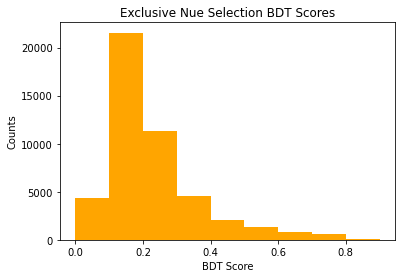

In [29]:
#plot_data('BDT_score', [x/10 for x in range(11)], 0, 1, '', datasets_bdt, ISRUN3, 
#          plt_norm='pot', ymax=150, x_label='BDT Score') 
#print(datasets_bdt)

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [ ]:
###Need to use the same BDT split value Katerina did
#It was BDT score > 0.575

In [30]:
import plotter
import importlib
importlib.reload(plotter)

samples = {
    "mc"  : overlay,
    "nue" : nue,
    "data": data,
    "dirt": dirt,
    "ext" : ext
}

pot       =  2e+20 

weights = { "mc"  : 1,
            "nue"  : 1, 
            "nue" : 1,
            "ext" : 1,    
            "dirt": 1,   
}

my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

{'mc': 1, 'nue': 1, 'ext': 1, 'dirt': 1}


BDT_score > 0& BDT_score <= 1 & BDT_score >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  4682.538474885238  c  3
order w sum  6437.156258768204  c  21
order w sum  8593.126337721009  c  31
order w sum  9698.895270719906  c  5
order w sum  12137.280314912745  c  2
order w sum  2027.0768335886116  c  1
order w sum  0  c  12
order w sum  1120.9904543194725  c  10
order w sum  3460.2765182957496  c  11
total  54244.34046321094
[ 674.183 2200.63  1028.87   442.826  203.834   95.343   31.424    5.428
    0.       0.   ]
sum:  4682.538474885238
[ 855.894 4475.327 3611.34  1417.103  449.242  210.123   85.441   15.225
    0.       0.   ]
sum:  11119.694733653441
[1.288e+03 8.044e+03 5.797e+03 2.582e+03 1.088e+03 6.368e+02 2.339e+02
 4.309e+01 1.033e+00 0.000e+00]
sum:  19712.821071374445
[3.815e+03 1.320e+04 7.193e+03 2.960e+03 1.214e+03 7.076e+02 2.632e+02
 5.205e+01 1.399e+00 0.000e+00]
sum:  29411.716342094358
[5.021e+03 2.024e+04 9.942e+03 3.618e+03 1.454e+03 8.463e+02 

NameError: name 'overlay' is not defined

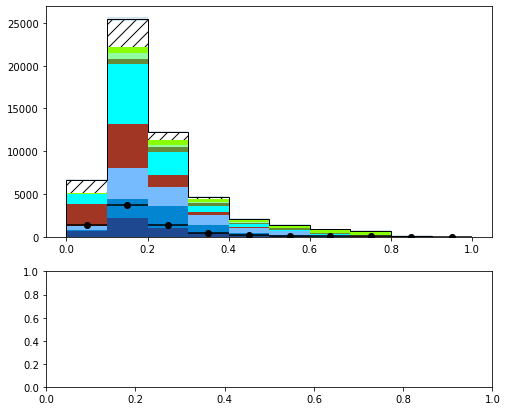

In [36]:
import matplotlib.pyplot as plt
import matplotlib

SEL_QUERY = "BDT_score > 0"

VARIABLE, BINS, RANGE, XTIT = 'BDT_score',10,(0.0, 1.0),"Reconstructed Energy [GeV]"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    #kind="interaction",
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = False, 
    draw_data = True,
    genieweight = "totweight_overlay",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - Reconstructed Energies',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()

In [ ]:
# Plot MC, normalized to beam on, overlay, OR projected 
# NEED TO ADD: GENIE UNSIMS, NON-nueCC DET SYS
def plot_mc(var, nbins, xlow, xhigh, cuts, datasets, isrun3, plt_norm='overlay', pot=None, save=False, save_label=None, log=False, x_label=None, ymax=None, sys=False, bdt_scale=None, text=None, xtext=None, ytext=None, osc=None, createDict=False):
    
    ############################
    # str var --> variable on x
    # nbins --> # of bins in histogram 
    # xlow, xhigh --> histogram x bounds
    # str cuts --> cuts query applied to data set (string)
    # datasets = list of [df_infv, df_outfv, df_cosmic, df_ext, df_data] in that order 
    # str save_label --> what label to save to pdf as? 
    # bool save --> save as pdf? 
    # bool log --> y log the plot? 
    # str plt_norm --> what POT do we want to scale to: data (totweight), overlay, or proj?
    # str x_label --> label of the x-axis for the histogram 
    ############################
    
    
    # set the POT & plots_path for plotting
    #plots_path = plot_param(isrun3)[1]
    
    #if (plt_norm == 'data'): 
    #    pot = plot_param(isrun3)[0]
    #elif (plt_norm=='overlay'): 
    #    pot = plot_param(isrun3)[2]
    #elif (plt_norm =='proj'):
    #    pot = plot_param(isrun3)[3]

    if (cuts==""): 
        infv = datasets[0]
        outfv = datasets[1]
        cosmic = datasets[2]
        ext = datasets[3]
        
    else: 
        infv = datasets[0].query(cuts) 
        outfv = datasets[1].query(cuts)
        cosmic = datasets[2].query(cuts)
        ext = datasets[3].query(cuts) 
    
    ## MC weights
    categories = [cosmic, outfv, 
                        infv.query(numu_NC_Npi0), 
                        infv.query(numu_CC_Npi0), 
                        infv.query(numu_NC_0pi0), 
                        infv.query(numu_CC_0pi0), 
                        infv.query(nue_NC), 
                        infv.query(nue_CCother), 
                        #infv.query(numu_Npi0), 
                        #infv.query(numu_0pi0), 
                        #infv.query(nue_other),
                        infv.query(nuebar_1eNp), 
                        infv.query(signal),
                        ext]
    
    ## Legend counters
    norm = ''
    ext_norm = ''
    
    mc_weights = []
    if (plt_norm=='data'): 
        if bdt_scale is not None: 
            mc_weights = [[ x/bdt_scale for x in d['totweight'] ] for d in categories[:-1]]
            mc_weights.append( [x/bdt_scale for x in categories[-1]['pot_scale']] )
        #else: 
        mc_weights = [d['totweight'] for d in categories[:-1]]
        mc_weights.append( categories[-1]['pot_scale'] )
        
        norm = 'totweight'
        ext_norm = 'pot_scale'
    
    elif (plt_norm=='overlay'):
        if bdt_scale is not None: 
            mc_weights = [[ x/bdt_scale for x in d['totweight_overlay'] ] for d in categories[:-1]]
            mc_weights.append( [x/bdt_scale for x in categories[-1]['pot_scale_overlay']] )
            
        #else: 
        mc_weights = [d['totweight_overlay'] for d in categories[:-1]]
        mc_weights.append( categories[-1]['pot_scale_overlay'] )
        
        norm = 'totweight_overlay'
        ext_norm = 'pot_scale_overlay'
    
    elif (plt_norm=='proj'):
        if bdt_scale is not None: 
            mc_weights = [[ x/bdt_scale for x in d['totweight_proj'] ] for d in categories[:-1]]
            mc_weights.append( [x/bdt_scale for x in categories[-1]['pot_scale_proj']] )
        
        #else:  
        mc_weights = [d['totweight_proj'] for d in categories[:-1]]
        mc_weights.append( categories[-1]['pot_scale_proj'] )
        
        norm = 'totweight_proj'
        ext_norm = 'pot_scale_proj'
        
    
    # event counts
    counts = [round(sum(cosmic[norm]), 1), 
             round(sum(outfv[norm]), 1), 
             round(sum(infv.query(numu_NC_Npi0)[norm]), 1), 
             round(sum(infv.query(numu_CC_Npi0)[norm]), 1), 
             round(sum(infv.query(numu_NC_0pi0)[norm]), 1), 
             round(sum(infv.query(numu_CC_0pi0)[norm]), 1), 
             round(sum(infv.query(nue_NC)[norm]), 1), 
             round(sum(infv.query(nue_CCother)[norm]), 1), 
             round(sum(infv.query(numu_Npi0)[norm]), 1), 
             round(sum(infv.query(numu_0pi0)[norm]), 1), 
             round(sum(infv.query(nue_other)[norm]), 1), 
             round(sum(infv.query(nuebar_1eNp)[norm]), 1), 
             round(sum(infv.query(signal)[norm]), 1), 
             round(sum(ext[ext_norm]), 1)]
    
    if bdt_scale is not None: 
        counts = [ x/bdt_scale for x in counts]

    
    # legend 
    leg = [labels['cosmic'][0]+': '+str(counts[0]), 
                        labels['out_fv'][0]+': '+str(counts[1]), 
                        labels['numu_NC_Npi0'][0]+': '+str(counts[2]), 
                        labels['numu_CC_Npi0'][0]+': '+str(counts[3]), 
                        labels['numu_NC_0pi0'][0]+': '+str(counts[4]), 
                        labels['numu_CC_0pi0'][0]+': '+str(counts[5]), 
                        labels['nue_NC'][0]+': '+str(counts[6]), 
                        labels['nue_CCother'][0]+': '+str(counts[7]),
                        #labels['numu_Npi0'][0]+': '+str(counts[8]), 
                        #labels['numu_0pi0'][0]+': '+str(counts[9]), 
                        #labels['nue_other'][0]+': '+str(counts[10]), 
                        labels['nuebar_1eNp'][0]+': '+str(counts[11]), 
                        labels['signal'][0]+': '+str(counts[12]), 
                        labels['ext'][0]+': '+str(counts[13])]
    
    #######################################
    # calclulate the errors before plotting 
    
    stat_err = percent_stat_error(var, nbins, xlow, xhigh, [infv, outfv, cosmic, ext])
    
    if sys: 
        ppfx_err = calcSysError(var, nbins, xlow, xhigh, cuts, datasets, 'weightsPPFX', 600, plot=False)
        beamline_err = calcSysError(var, nbins, xlow, xhigh, cuts, datasets, 'weightsNuMIGeo', 20, plot=False)
        genie_err = calcSysError(var, nbins, xlow, xhigh, cuts, datasets, 'weightsGenie', 600, plot=False)
        reint_err = calcSysError(var, nbins, xlow, xhigh, cuts, datasets, 'weightsReint', 1000, plot=False)
        #det_err_bkgd = calcDetSysError(var, nbins, intrinsic=False)
        det_err_nueCC = calcDetSysError(var, nbins, intrinsic=True)
        #print(ppfx_err)
        
    #######################################
    
    
    ################################################################## 
    # oscillated event rate
    if osc:
        
        # plot signal only 
        n_sig, b_sig, p_sig = plt.hist(infv.query(signal)[var], nbins, histtype='bar', range=[xlow, xhigh], weights=mc_weights[-2])
        plt.close()
        #print(n_sig)
        
        osc_weight = []
        
        with open(osc) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            for row in csv_reader:
                if line_count > 0: 
                    osc_weight.append(float(row[0]))
                    #bin_centers.append(float(row[1]))
                    
                line_count += 1

        osc_counts = [ a*b for a, b in zip(n_sig,osc_weight) ]
        
    ##################################################################  
    
    
    # now to actually plot 
    fig = plt.figure(figsize=(8, 5))
    n, b, p = plt.hist([cosmic[var], 
                       outfv[var], 
                       infv.query(numu_NC_Npi0)[var],
                       infv.query(numu_CC_Npi0)[var],
                       infv.query(numu_NC_0pi0)[var],
                       infv.query(numu_CC_0pi0)[var],
                       infv.query(nue_NC)[var],
                       infv.query(nue_CCother)[var],
                       #infv.query(numu_Npi0)[var], 
                       #infv.query(numu_0pi0)[var], 
                       #infv.query(nue_other)[var],
                       infv.query(nuebar_1eNp)[var], 
                       infv.query(signal)[var],
                       ext[var]],
            nbins, histtype='bar', range=[xlow, xhigh], stacked=True, 
            color=[labels['cosmic'][1], 
                       labels['out_fv'][1], 
                       labels['numu_NC_Npi0'][1], 
                       labels['numu_CC_Npi0'][1], 
                       labels['numu_NC_0pi0'][1], 
                       labels['numu_CC_0pi0'][1], 
                       labels['nue_NC'][1], 
                       labels['nue_CCother'][1],
                       #labels['numu_Npi0'][1], 
                       #labels['numu_0pi0'][1], 
                       #labels['nue_other'][1], 
                       labels['nuebar_1eNp'][1], 
                       labels['signal'][1], 
                       labels['ext'][1]], 
            label=leg,
            weights=mc_weights)
    
    # total selected 
    print('total selected = '+str(sum(n[-1])))
    
    # scale percent stat error to the # of events in hist bins
    stat_err_scaled = [x*y for x, y in zip(n[-1], stat_err)]

    if sys:   
        # scale to the (weighted?) number of events 
        ppfx_err_scaled = [x*y for x, y in zip(n[-1], ppfx_err[1])]
        beamline_err_scaled = [x*y for x, y in zip(n[-1], beamline_err[1])]
        genie_err_scaled = [x*y for x, y in zip(n[-1], genie_err[1])]
        reint_err_scaled = [x*y for x, y in zip(n[-1], reint_err[1])]
        #det_err_bkgd_scaled = [x*y for x, y in zip(n[-1], det_err_bkgd[1])]
        det_err_nueCC_scaled = [x*y for x, y in zip(n[-1], det_err_nueCC[1])]
        
        # add in quadrature the stat error & the sys error 
        tot_err = [ np.sqrt(u**2 + v**2 + w**2 + x**2 + y**2 + z**2) for u,v,w,x,y,z in zip(stat_err_scaled, ppfx_err_scaled, beamline_err_scaled, genie_err_scaled, reint_err_scaled, det_err_nueCC_scaled) ]
        
        #tot_err = [ np.sqrt(t**2 + u**2 + v**2 + w**2 + x**2 + y**2 + z**2) for t, u,v,w,x,y,z in zip(stat_err_scaled, ppfx_err_scaled, beamline_err_scaled, genie_err_scaled, reint_err_scaled, det_err_bkgd_scaled, det_err_nueCC_scaled) ]
        
    else: 
        tot_err = stat_err_scaled
    
    bincenters = 0.5*(b[1:]+b[:-1])
    plt.errorbar(bincenters, n[-1], yerr=tot_err, fmt='none', color='black', linewidth=1)
    
    # error outline 
    tot = list([0, n[-1][0]])+list(n[-1])+[0]
    b_step = list([b[0]])+list(b)+list([b[-1]])
    plt.step(b_step, tot, color='black', linewidth=.7)
      
    ##################################################################  
    if osc:    
        # add in unoscillated background 
        osc_counts = list([0, osc_counts[0]])+osc_counts+[0]
        sig_counts = list([0, n_sig[0]])+list(n_sig)+[0]
        bkgd_counts = [y-z for y, z in zip(tot,sig_counts)]
        osc_counts = [a+b for a,b in zip(osc_counts, bkgd_counts)]
        
        plt.step(b_step, osc_counts, color='darkblue', linestyle='dashed')
    ##################################################################  
        
    # plot format stuff
    plt.legend(loc='best', prop={"size":10}, ncol=3, frameon=False)
        
    if pot is not None: 
        plt.ylabel("$\\nu$ / "+pot+" POT", fontsize=15)
    
    if x_label:
        plt.xlabel(x_label, fontsize=15)
    else: 
        plt.xlabel(var, fontsize=15)
    
    plt.xlim(xlow, xhigh)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    if log: 
        plt.yscale('log')
        
    if ymax: 
        if log: 
            plt.ylim(1, ymax)
        else: 
            plt.ylim(0, ymax)
            
    if text: 
        plt.text(xtext, ytext, text, fontsize='xx-large', horizontalalignment='right')
    
    if save: 
        plt.savefig(plots_path+var+"_"+save_label+".pdf", transparent=True, bbox_inches='tight') 
        print('saving to: '+plots_path)
        
    plt.show()
    ###########################################
    # return python dictionary with bins, CV, & fractional uncertainties 
    d = { 
       "bins" : nbins, 
        "CV" : list(n[-1]), 
        "stat" : stat_err
    }
    
    if sys: 
        d["ppfx"] = ppfx_err[1], 
        d["beamline"] = beamline_err[1],
        d["genie"] = genie_err[1], 
        d["reint"] = reint_err[1],
        d["det_intrinsic"] = det_err_nueCC[1], 
        d["tot"] = [ x/y for x,y in zip(tot_err, n[-1]) ]  
    
    else: 
        d["tot"] = [ x/y for x,y in zip(tot_err, n[-1]) ]  
    ###########################################

    # returns 2D list of percent errors for each source of systematic, 1D list of total percent errors
    return d


In [ ]:
plot_mc('nu_e', 20, 0, 5, 'BDT_score > 0.5', datasets_bdt, ISRUN3, False, False, ISRUN3, 'totweight_overlay', ymax=140)